#### Human activity classification with convolutional encoder feature representations

The model architecture and feature engineering methods from the following paper are implemented

[On the Role of Features in HAR](https://dl.acm.org/doi/10.1145/3341163.3347727)

Classification: probabilistic classification with MLP

In [1]:
import torch
import numpy as np
import os
import pandas as pd
import json
import sys

import torch
import torch.nn.functional as F

import skopt
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt import callbacks
from skopt.callbacks import CheckpointSaver

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sys.executable

'c:\\Users\\arthu\\AppData\\Local\\Programs\\Python\\Python311\\python.exe'

In [3]:

module_dir = "../modules"
if module_dir not in sys.path:
    sys.path.append(module_dir)
    
from enc_class_training_loop import train_and_save_conv_classifier
from frame_dataloader_heavy import WorkloadFrame
import utils

# if there is trouble installing modules: compare python paths used in notebooks vs cmd
# print(sys.executable)
# !python -c "import sys; print(sys.executable)"

# install modules to the currently used python path in cmd
#%pip install scikit-optimize
# OR
#"C:\path\to\your\jupyter\python.exe" -m pip install scikit-optimize

# check what env jupyter is using, install the correct one
# jupyter kernelspec list
# python -m ipykernel install --user --name myenv --display-name "Python (myenv)"

# saving project requirements:
# pip freeze > requirements.txt
# pip install -r requirements.txt



#### Probing 1
evaluating classification output

In [6]:
target = F.one_hot(torch.randint(0, 4, (64, )), num_classes=4)
target.shape

torch.Size([64, 4])

In [7]:
classification = F.softmax(torch.randn((64, 4)), dim=1)
classification.shape

torch.Size([64, 4])

In [12]:
accuracy = 0.0
accuracy += torch.sum(torch.argmax(classification, dim=1) == torch.argmax(target, dim=1))
accuracy, type(accuracy), int(accuracy), type(int(accuracy))

(tensor(15.), torch.Tensor, 15, int)

#### Probing

Early stopping and learning rate heuristics

In [4]:
a = F.one_hot(torch.tensor(3), 5)
b = F.one_hot(torch.tensor(1), 5)
a, b

(tensor([0, 0, 0, 1, 0]), tensor([0, 1, 0, 0, 0]))

In [5]:
torch.argmax(a)

tensor(3)

In [6]:
s = pd.Series([1, 2, 3, 4, 5, 6,7])
x = s[-12:].values**2
y = np.arange(len(x))
grad = np.gradient(y, x)

grad

array([0.33333333, 0.28333333, 0.17619048, 0.12896825, 0.1020202 ,
       0.08449883, 0.07692308])

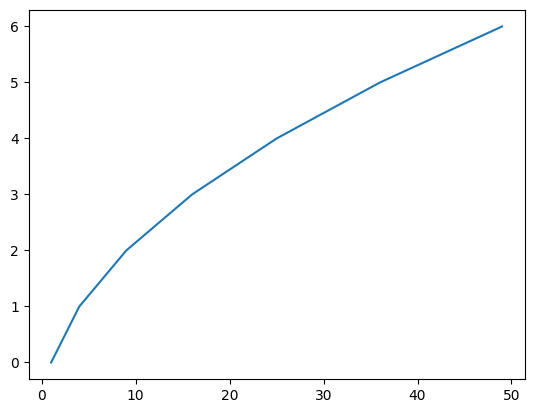

In [7]:
plt.plot(x, y)

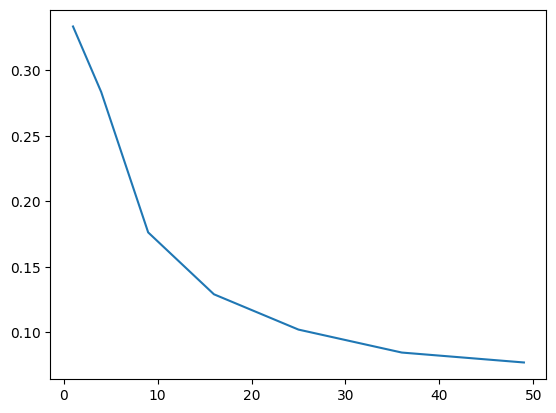

In [8]:
plt.plot(x, grad)

#### Bayesian Parameter Optimization

Finds objective Loss function of model hyperparameters 

- randomly samples parameter space via initial_point_generator for n_initialial_points
- observes function values and approximates function with gaussian prior
- updates prior based on observed values

The optimization result returned as a OptimizeResult object. Saved attributes are:
```
x [list]: location of the minimum.

fun [float]: function value at the minimum.

x_iters [list of lists]: location of function evaluation for each iteration.

func_vals [array]: function value for each iteration.

space [Space]: the optimization space

specs [dict]`: the call specifications.

rng [RandomState instance]: State of the random state at the end of minimization.
```
For more details related to the OptimizeResult object, see [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html)

for more, see [Documentation](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize)

#### Training log:


$BayesOpt2Error$ minimized % classification error with the 'phys' group labels but provided poor results due to bug in model evaluation

$BayesOpt3ErrorPhys$ runs across all hyperparameters except # conv blocks, minimizing % classification error whilst using the 'phys' group labels. Failed due to overfitting

$BayesOpt4ErrorPhys$ runs across hidden and latent dim, minimizing % classification error. Uses (10, 2) convolution kernel, with 2 convolution blocks starting at 4 channels

In [12]:
param_space = [
    Integer(4,  32, name='hidden_dim'), # hidden layer dimension
    Integer(4, 32, name='latent_dim'), # latent dimension
    #Integer(4, 8, name='init_channel'), # initial channel size 
    #Integer(1, 4, name='kernel_height'),
    #Integer(1, 4, name='kernel_width'),
    #Integer(1, 4, name='conv_blocks'), # number of convolutional blocks
]

# trainig epochs must stay same if optim run is interrupted to prevent skewing of loss landscape
optim_name = 'BayesOpt4CustomArch'
save_filepath = "..\\saved_models\\classifier\\bayes_opt4\\"
training_epochs = 50


file_dir='..\\files'
#  file group: 'phys', 'cog', or 'tot'
group='phys'
# signal channel to resample to: 'temp', 'hrv, 'hr', 'hbo', 'eda'
resample='temp'
# size of sliding window relative to shortest signal length; always 50% overlap between windows
context_length=0.5
frames = WorkloadFrame(dir=file_dir, group=group, resample=resample, context_length=context_length)

checkpoint_saver = CheckpointSaver(save_filepath+optim_name+'.pkl', compress=9)

def objective_error(x):
    hdim, ldim = x
    hdim, ldim = int(hdim), int(ldim)
    print(f'Evaluation point: \n hdim {hdim} ldim {ldim}')

    config = {'latent_dim':ldim, 'conv_blocks':[1, 2, 4], 'hidden_dim':hdim, 'kernel':(10, 2), 'id':optim_name}
    accuracy = train_and_save_conv_classifier(config=config, num_epochs=training_epochs, save_filepath=save_filepath, dataset=frames, batch_size=32, initlr=1e-3)
    print(f'Achieved final accuracy of {accuracy}')
    error = 1-accuracy
    return error

In [13]:
torch.cuda.empty_cache()
objective_error((5, 7))

Evaluation point: 
 hdim 5 ldim 7
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4827755689620972
No saved weights found for conv_classifier_ldim7_convblocks3_hdim5_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim7_convblocks3_hdim5_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim7_convblocks3_hdim5_kernel(10, 2)_idBayesOpt4CustomArch')


ACCURACY: 0.35433071851730347 TRUEPOS 135.0 EVALS 381.0


ACCURACY: 0.38057741522789 TRUEPOS 145.0 EVALS 381.0


ACCURACY: 0.38320210576057434 TRUEPOS 146.0 EVALS 381.0


ACCURACY: 0.39895012974739075 TRUEPOS 152.0 EVALS 381.0


ACCURACY: 0.4094488024711609 TRUEPOS 156.0 EVALS 381.0


ACCURACY: 0.43832021951675415 TRUEPOS 167.0 EVALS 381.0


ACCURACY: 0.41469815373420715 TRUEPOS 158.0 EVALS 381.0


ACCURACY: 0.443569540977478 TRUEPOS 169.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.40682414174079895 TRUEPOS 155.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim7_convblocks3_hdim5_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=217.0, total_evals=381.0, accuracy=0.569553792476654
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.569553792476654


0.43044620752334595

In [14]:
!which python

/c/Users/arthu/AppData/Local/Programs/Python/Python311/python


In [15]:
torch.cuda.empty_cache()
result = gp_minimize(
    objective_error, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=50, # total function calls
    n_initial_points=30, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    callback=[checkpoint_saver],
    noise=1e-10
)

Iteration No: 1 started. Evaluating function at random point.
Evaluation point: 
 hdim 10 ldim 13
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.5136115550994873
No saved weights found for conv_classifier_ldim13_convblocks3_hdim10_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim13_convblocks3_hdim10_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim13_convblocks3_hdim10_kernel(10, 2)_idBayesOpt4CustomArch')


ACCURACY: 0.29921260476112366 TRUEPOS 114.0 EVALS 381.0


ACCURACY: 0.3963254690170288 TRUEPOS 151.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.443569540977478 TRUEPOS 169.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim13_convblocks3_hdim10_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=202.0, total_evals=381.0, accuracy=0.530183732509613
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.530183732509613
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 43.0435
Function value obtained: 0.4698
Current minimum: 0.4698
Iteration No: 2 started. Evaluating function at random point.
Evaluation point: 
 hdim 31 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.501242756843567
No saved weights found for conv_classifier_ldim17_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch

ACCURACY: 0.4094488024711609 TRUEPOS 156.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=201.0, total_evals=381.0, accuracy=0.5275590419769287
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5275590419769287
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 41.3817
Function value obtained: 0.4724
Current minimum: 0.4698
Iteration No: 3 started. Evaluating function at random point.
Evaluation point: 
 hdim 13 ldim 11
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4123687744140625
No saved weights found for conv_classifier_ldim11_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim11_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 e

ACCURACY: 0.41469815373420715 TRUEPOS 158.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim11_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=199.0, total_evals=381.0, accuracy=0.5223097205162048
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5223097205162048
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 48.9069
Function value obtained: 0.4777
Current minimum: 0.4698
Iteration No: 4 started. Evaluating function at random point.
Evaluation point: 
 hdim 6 ldim 16
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.5171644687652588
No saved weights found for conv_classifier_ldim16_convblocks3_hdim6_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim16_convblocks3_hdim6_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoc

ACCURACY: 0.3727034032344818 TRUEPOS 142.0 EVALS 381.0


ACCURACY: 0.41469815373420715 TRUEPOS 158.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4488188922405243 TRUEPOS 171.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.4330708682537079 TRUEPOS 165.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim16_convblocks3_hdim6_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=201.0, total_evals=381.0, accuracy=0.5275590419769287
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5275590419769287
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 45.1908
Function value obtained: 0.4724
Current minimum: 0.4698
Iteration No: 5 started. Evaluating function at random point.
Evaluation point: 
 hdim 4 ldim 19
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4705406427383423
No saved weights found for conv_classifier_ldim19_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim19_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch

ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.6115485429763794 TRUEPOS 233.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.6194225549697876 TRUEPOS 236.0 EVALS 381.0


ACCURACY: 0.6220472455024719 TRUEPOS 237.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.6377952694892883 TRUEPOS 243.0 EVALS 381.0


ACCURACY: 0.6404199600219727 TRUEPOS 244.0 EVALS 381.0


ACCURACY: 0.6246719360351562 TRUEPOS 238.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.6299212574958801 TRUEPOS 240.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim19_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=226.0, total_evals=381.0, accuracy=0.5931758284568787
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5931758284568787
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 45.5663
Function value obtained: 0.4068
Current minimum: 0.4068
Iteration No: 6 started. Evaluating function at random point.
Evaluation point: 
 hdim 28 ldim 13
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4328794479370117
No saved weights found for conv_classifier_ldim13_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim13_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 ep

ACCURACY: 0.34383201599121094 TRUEPOS 131.0 EVALS 381.0


ACCURACY: 0.43832021951675415 TRUEPOS 167.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6272965669631958 TRUEPOS 239.0 EVALS 381.0


ACCURACY: 0.6272965669631958 TRUEPOS 239.0 EVALS 381.0


ACCURACY: 0.6115485429763794 TRUEPOS 233.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim13_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=218.0, total_evals=381.0, accuracy=0.5721784830093384
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5721784830093384
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 44.0280
Function value obtained: 0.4278
Current minimum: 0.4068
Iteration No: 7 started. Evaluating function at random point.
Evaluation point: 
 hdim 15 ldim 23
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4142765998840332
No saved weights found for conv_classifier_ldim23_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim23_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 e

ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim23_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=180.0, total_evals=381.0, accuracy=0.4724409580230713
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.4724409580230713
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 52.8719
Function value obtained: 0.5276
Current minimum: 0.4068
Iteration No: 8 started. Evaluating function at random point.
Evaluation point: 
 hdim 23 ldim 23
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.3934516906738281
No saved weights found for conv_classifier_ldim23_convblocks3_hdim23_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim23_convblocks3_hdim23_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 e

ACCURACY: 0.43832021951675415 TRUEPOS 167.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim23_convblocks3_hdim23_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=197.0, total_evals=381.0, accuracy=0.5170603394508362
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5170603394508362
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 50.2449
Function value obtained: 0.4829
Current minimum: 0.4068
Iteration No: 9 started. Evaluating function at random point.
Evaluation point: 
 hdim 14 ldim 30
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.3784877061843872
No saved weights found for conv_classifier_ldim30_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim30_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 e

ACCURACY: 0.4173228442668915 TRUEPOS 159.0 EVALS 381.0


ACCURACY: 0.4409448802471161 TRUEPOS 168.0 EVALS 381.0


ACCURACY: 0.45406824350357056 TRUEPOS 173.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim30_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=192.0, total_evals=381.0, accuracy=0.5039370059967041
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5039370059967041
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 42.9152
Function value obtained: 0.4961
Current minimum: 0.4068
Iteration No: 10 started. Evaluating function at random point.
Evaluation point: 
 hdim 11 ldim 25
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.54475998878479
No saved weights found for conv_classifier_ldim25_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim25_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 ep

ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.6194225549697876 TRUEPOS 236.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.6115485429763794 TRUEPOS 233.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim25_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=224.0, total_evals=381.0, accuracy=0.5879265069961548
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5879265069961548
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 42.8803
Function value obtained: 0.4121
Current minimum: 0.4068
Iteration No: 11 started. Evaluating function at random point.
Evaluation point: 
 hdim 11 ldim 28
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.3698176145553589
No saved weights found for conv_classifier_ldim28_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim28_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.443569540977478 TRUEPOS 169.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.4330708682537079 TRUEPOS 165.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim28_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=181.0, total_evals=381.0, accuracy=0.4750656187534332
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.4750656187534332
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 42.8070
Function value obtained: 0.5249
Current minimum: 0.4068
Iteration No: 12 started. Evaluating function at random point.
Evaluation point: 
 hdim 9 ldim 26
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.6243606805801392
No saved weights found for conv_classifier_ldim26_convblocks3_hdim9_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim26_convblocks3_hdim9_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 ep

ACCURACY: 0.36745405197143555 TRUEPOS 140.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim26_convblocks3_hdim9_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=199.0, total_evals=381.0, accuracy=0.5223097205162048
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5223097205162048
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 42.8587
Function value obtained: 0.4777
Current minimum: 0.4068
Iteration No: 13 started. Evaluating function at random point.
Evaluation point: 
 hdim 30 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.47251558303833
No saved weights found for conv_classifier_ldim17_convblocks3_hdim30_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim30_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 ep

ACCURACY: 0.4330708682537079 TRUEPOS 165.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim30_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=221.0, total_evals=381.0, accuracy=0.5800524950027466
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5800524950027466
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 43.7011
Function value obtained: 0.4199
Current minimum: 0.4068
Iteration No: 14 started. Evaluating function at random point.
Evaluation point: 
 hdim 15 ldim 14
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4615094661712646
No saved weights found for conv_classifier_ldim14_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim14_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.4278215169906616 TRUEPOS 163.0 EVALS 381.0


ACCURACY: 0.44619423151016235 TRUEPOS 170.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim14_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=222.0, total_evals=381.0, accuracy=0.5826771855354309
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5826771855354309
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 45.6431
Function value obtained: 0.4173
Current minimum: 0.4068
Iteration No: 15 started. Evaluating function at random point.
Evaluation point: 
 hdim 9 ldim 7
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.50564444065094
No saved weights found for conv_classifier_ldim7_convblocks3_hdim9_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim7_convblocks3_hdim9_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 

ACCURACY: 0.35170602798461914 TRUEPOS 134.0 EVALS 381.0


ACCURACY: 0.40682414174079895 TRUEPOS 155.0 EVALS 381.0


ACCURACY: 0.4409448802471161 TRUEPOS 168.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim7_convblocks3_hdim9_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=196.0, total_evals=381.0, accuracy=0.5144357085227966
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5144357085227966
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 45.6125
Function value obtained: 0.4856
Current minimum: 0.4068
Iteration No: 16 started. Evaluating function at random point.
Evaluation point: 
 hdim 18 ldim 21
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.404600977897644
No saved weights found for conv_classifier_ldim21_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim21_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 ep

ACCURACY: 0.36220473051071167 TRUEPOS 138.0 EVALS 381.0


ACCURACY: 0.4356955289840698 TRUEPOS 166.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim21_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=185.0, total_evals=381.0, accuracy=0.48556429147720337
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.48556429147720337
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 41.9872
Function value obtained: 0.5144
Current minimum: 0.4068
Iteration No: 17 started. Evaluating function at random point.
Evaluation point: 
 hdim 31 ldim 14
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.369679570198059
No saved weights found for conv_classifier_ldim14_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim14_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from

ACCURACY: 0.40682414174079895 TRUEPOS 155.0 EVALS 381.0


ACCURACY: 0.42257216572761536 TRUEPOS 161.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim14_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=188.0, total_evals=381.0, accuracy=0.4934383034706116
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.4934383034706116
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 42.8645
Function value obtained: 0.5066
Current minimum: 0.4068
Iteration No: 18 started. Evaluating function at random point.
Evaluation point: 
 hdim 12 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4024991989135742
No saved weights found for conv_classifier_ldim17_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.43832021951675415 TRUEPOS 167.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.635170578956604 TRUEPOS 242.0 EVALS 381.0


ACCURACY: 0.6272965669631958 TRUEPOS 239.0 EVALS 381.0


ACCURACY: 0.635170578956604 TRUEPOS 242.0 EVALS 381.0


ACCURACY: 0.6272965669631958 TRUEPOS 239.0 EVALS 381.0


ACCURACY: 0.6246719360351562 TRUEPOS 238.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.6299212574958801 TRUEPOS 240.0 EVALS 381.0


ACCURACY: 0.6299212574958801 TRUEPOS 240.0 EVALS 381.0


ACCURACY: 0.6246719360351562 TRUEPOS 238.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.6194225549697876 TRUEPOS 236.0 EVALS 381.0


ACCURACY: 0.6194225549697876 TRUEPOS 236.0 EVALS 381.0


ACCURACY: 0.6194225549697876 TRUEPOS 236.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.6115485429763794 TRUEPOS 233.0 EVALS 381.0


ACCURACY: 0.6115485429763794 TRUEPOS 233.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6115485429763794 TRUEPOS 233.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.6194225549697876 TRUEPOS 236.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=236.0, total_evals=381.0, accuracy=0.6194225549697876
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.6194225549697876
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 42.9530
Function value obtained: 0.3806
Current minimum: 0.3806
Iteration No: 19 started. Evaluating function at random point.
Evaluation point: 
 hdim 31 ldim 9
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4249367713928223
No saved weights found for conv_classifier_ldim9_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim9_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 ep

ACCURACY: 0.3963254690170288 TRUEPOS 151.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim9_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=185.0, total_evals=381.0, accuracy=0.48556429147720337
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.48556429147720337
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 42.5181
Function value obtained: 0.5144
Current minimum: 0.3806
Iteration No: 20 started. Evaluating function at random point.
Evaluation point: 
 hdim 8 ldim 6
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4175219535827637
No saved weights found for conv_classifier_ldim6_convblocks3_hdim8_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim6_convblocks3_hdim8_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epo

ACCURACY: 0.3727034032344818 TRUEPOS 142.0 EVALS 381.0


ACCURACY: 0.4356955289840698 TRUEPOS 166.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim6_convblocks3_hdim8_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=214.0, total_evals=381.0, accuracy=0.5616797804832458
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5616797804832458
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 43.9588
Function value obtained: 0.4383
Current minimum: 0.3806
Iteration No: 21 started. Evaluating function at random point.
Evaluation point: 
 hdim 19 ldim 13
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.6134880781173706
No saved weights found for conv_classifier_ldim13_convblocks3_hdim19_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim13_convblocks3_hdim19_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 e

ACCURACY: 0.4094488024711609 TRUEPOS 156.0 EVALS 381.0


ACCURACY: 0.4356955289840698 TRUEPOS 166.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim13_convblocks3_hdim19_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=206.0, total_evals=381.0, accuracy=0.5406824350357056
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5406824350357056
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 42.8048
Function value obtained: 0.4593
Current minimum: 0.3806
Iteration No: 22 started. Evaluating function at random point.
Evaluation point: 
 hdim 12 ldim 30
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4448338747024536
No saved weights found for conv_classifier_ldim30_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim30_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.3700787425041199 TRUEPOS 141.0 EVALS 381.0


ACCURACY: 0.42257216572761536 TRUEPOS 161.0 EVALS 381.0


ACCURACY: 0.4278215169906616 TRUEPOS 163.0 EVALS 381.0


ACCURACY: 0.4409448802471161 TRUEPOS 168.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4488188922405243 TRUEPOS 171.0 EVALS 381.0


ACCURACY: 0.4409448802471161 TRUEPOS 168.0 EVALS 381.0


ACCURACY: 0.43044620752334595 TRUEPOS 164.0 EVALS 381.0


ACCURACY: 0.4488188922405243 TRUEPOS 171.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim30_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=194.0, total_evals=381.0, accuracy=0.509186327457428
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.509186327457428
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 44.4237
Function value obtained: 0.4908
Current minimum: 0.3806
Iteration No: 23 started. Evaluating function at random point.
Evaluation point: 
 hdim 16 ldim 16
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.5185942649841309
No saved weights found for conv_classifier_ldim16_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim16_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 ep

ACCURACY: 0.3779527544975281 TRUEPOS 144.0 EVALS 381.0


ACCURACY: 0.4330708682537079 TRUEPOS 165.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim16_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=211.0, total_evals=381.0, accuracy=0.5538057684898376
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5538057684898376
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 44.8098
Function value obtained: 0.4462
Current minimum: 0.3806
Iteration No: 24 started. Evaluating function at random point.
Evaluation point: 
 hdim 32 ldim 26
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.5084054470062256
No saved weights found for conv_classifier_ldim26_convblocks3_hdim32_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim26_convblocks3_hdim32_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim26_convblocks3_hdim32_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=211.0, total_evals=381.0, accuracy=0.5538057684898376
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5538057684898376
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 42.6304
Function value obtained: 0.4462
Current minimum: 0.3806
Iteration No: 25 started. Evaluating function at random point.
Evaluation point: 
 hdim 14 ldim 12
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.5096189975738525
No saved weights found for conv_classifier_ldim12_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim12_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.3018372654914856 TRUEPOS 115.0 EVALS 381.0


ACCURACY: 0.404199481010437 TRUEPOS 154.0 EVALS 381.0


ACCURACY: 0.4330708682537079 TRUEPOS 165.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


c:\Users\arthu\repo\msthesis\model_training\../modules\enc_class_training_loop.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(mo

ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim12_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=215.0, total_evals=381.0, accuracy=0.5643044710159302
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5643044710159302
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 44.0976
Function value obtained: 0.4357
Current minimum: 0.3806
Iteration No: 26 started. Evaluating function at random point.
Evaluation point: 
 hdim 18 ldim 21
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4854395389556885
Loaded state dict for conv_classifier_ldim21_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch
Existing log data found for 50 epochs
Ready to begin training from 50 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim21_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch')


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim21_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=186.0, total_evals=381.0, accuracy=0.4881889820098877
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.4881889820098877
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 43.3591
Function value obtained: 0.5118
Current minimum: 0.3806
Iteration No: 27 started. Evaluating function at random point.
Evaluation point: 
 hdim 22 ldim 11
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.3651130199432373
No saved weights found for conv_classifier_ldim11_convblocks3_hdim22_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim11_convblocks3_hdim22_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.42257216572761536 TRUEPOS 161.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


c:\Users\arthu\repo\msthesis\model_training\../modules\enc_class_training_loop.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(mo

ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim11_convblocks3_hdim22_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=217.0, total_evals=381.0, accuracy=0.569553792476654
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.569553792476654
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 44.5346
Function value obtained: 0.4304
Current minimum: 0.3806
Iteration No: 28 started. Evaluating function at random point.
Evaluation point: 
 hdim 15 ldim 23
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4337447881698608
Loaded state dict for conv_classifier_ldim23_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch
Existing log data found for 50 epochs
Ready to begin training from 50 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim23_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch')


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.44619423151016235 TRUEPOS 170.0 EVALS 381.0


ACCURACY: 0.45406824350357056 TRUEPOS 173.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.45406824350357056 TRUEPOS 173.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim23_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=180.0, total_evals=381.0, accuracy=0.4724409580230713
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.4724409580230713
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 44.5509
Function value obtained: 0.5276
Current minimum: 0.3806
Iteration No: 29 started. Evaluating function at random point.
Evaluation point: 
 hdim 16 ldim 26
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4414067268371582
No saved weights found for conv_classifier_ldim26_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim26_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim26_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=226.0, total_evals=381.0, accuracy=0.5931758284568787
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5931758284568787
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 47.6298
Function value obtained: 0.4068
Current minimum: 0.3806
Iteration No: 30 started. Evaluating function at random point.
Evaluation point: 
 hdim 23 ldim 25
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4479470252990723
No saved weights found for conv_classifier_ldim25_convblocks3_hdim23_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim25_convblocks3_hdim23_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0

ACCURACY: 0.4015747904777527 TRUEPOS 153.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim25_convblocks3_hdim23_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=207.0, total_evals=381.0, accuracy=0.5433070659637451
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5433070659637451
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 49.0080
Function value obtained: 0.4567
Current minimum: 0.3806
Iteration No: 31 started. Searching for the next optimal point.
Evaluation point: 
 hdim 12 ldim 16
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.5231539011001587
No saved weights found for conv_classifier_ldim16_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim16_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 

ACCURACY: 0.36220473051071167 TRUEPOS 138.0 EVALS 381.0


ACCURACY: 0.404199481010437 TRUEPOS 154.0 EVALS 381.0


ACCURACY: 0.44619423151016235 TRUEPOS 170.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim16_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=191.0, total_evals=381.0, accuracy=0.5013123154640198
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5013123154640198
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 47.0262
Function value obtained: 0.4987
Current minimum: 0.3806
Iteration No: 32 started. Searching for the next optimal point.
Evaluation point: 
 hdim 12 ldim 18
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.3603731393814087
No saved weights found for conv_classifier_ldim18_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim18_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin tra

ACCURACY: 0.4094488024711609 TRUEPOS 156.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim18_convblocks3_hdim12_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=195.0, total_evals=381.0, accuracy=0.5118110179901123
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5118110179901123
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 45.6727
Function value obtained: 0.4882
Current minimum: 0.3806
Iteration No: 33 started. Searching for the next optimal point.
Evaluation point: 
 hdim 11 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4253783226013184
No saved weights found for conv_classifier_ldim17_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin tra

ACCURACY: 0.4356955289840698 TRUEPOS 166.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim11_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=182.0, total_evals=381.0, accuracy=0.47769027948379517
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.47769027948379517
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 47.2227
Function value obtained: 0.5223
Current minimum: 0.3806
Iteration No: 34 started. Searching for the next optimal point.
Evaluation point: 
 hdim 14 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.2981656789779663
No saved weights found for conv_classifier_ldim17_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin 

ACCURACY: 0.3727034032344818 TRUEPOS 142.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=228.0, total_evals=381.0, accuracy=0.5984252095222473
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5984252095222473
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 48.0379
Function value obtained: 0.4016
Current minimum: 0.3806
Iteration No: 35 started. Searching for the next optimal point.
Evaluation point: 
 hdim 13 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4397432804107666
No saved weights found for conv_classifier_ldim17_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin tra

ACCURACY: 0.38057741522789 TRUEPOS 145.0 EVALS 381.0


ACCURACY: 0.404199481010437 TRUEPOS 154.0 EVALS 381.0


ACCURACY: 0.44619423151016235 TRUEPOS 170.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=193.0, total_evals=381.0, accuracy=0.5065616965293884
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5065616965293884
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 47.5939
Function value obtained: 0.4934
Current minimum: 0.3806
Iteration No: 36 started. Searching for the next optimal point.
Evaluation point: 
 hdim 17 ldim 18
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4448186159133911
No saved weights found for conv_classifier_ldim18_convblocks3_hdim17_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim18_convblocks3_hdim17_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin tra

ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.595800518989563 TRUEPOS 227.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim18_convblocks3_hdim17_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=219.0, total_evals=381.0, accuracy=0.5748031735420227
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5748031735420227
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 45.8210
Function value obtained: 0.4252
Current minimum: 0.3806
Iteration No: 37 started. Searching for the next optimal point.
Evaluation point: 
 hdim 15 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.39888334274292
No saved weights found for conv_classifier_ldim17_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin train

ACCURACY: 0.2939632534980774 TRUEPOS 112.0 EVALS 381.0


ACCURACY: 0.41469815373420715 TRUEPOS 158.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=222.0, total_evals=381.0, accuracy=0.5826771855354309
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5826771855354309
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 47.5254
Function value obtained: 0.4173
Current minimum: 0.3806
Iteration No: 38 started. Searching for the next optimal point.
Evaluation point: 
 hdim 14 ldim 16
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.5521208047866821
No saved weights found for conv_classifier_ldim16_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim16_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin tra

ACCURACY: 0.443569540977478 TRUEPOS 169.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim16_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=205.0, total_evals=381.0, accuracy=0.5380577445030212
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5380577445030212
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 46.0606
Function value obtained: 0.4619
Current minimum: 0.3806
Iteration No: 39 started. Searching for the next optimal point.
Evaluation point: 
 hdim 14 ldim 18
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.40812349319458
No saved weights found for conv_classifier_ldim18_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim18_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin train

ACCURACY: 0.4356955289840698 TRUEPOS 166.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim18_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=200.0, total_evals=381.0, accuracy=0.5249344110488892
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5249344110488892
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 47.2295
Function value obtained: 0.4751
Current minimum: 0.3806
Iteration No: 40 started. Searching for the next optimal point.
Evaluation point: 
 hdim 4 ldim 15
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4713289737701416
No saved weights found for conv_classifier_ldim15_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim15_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin traini

ACCURACY: 0.38320210576057434 TRUEPOS 146.0 EVALS 381.0


ACCURACY: 0.41469815373420715 TRUEPOS 158.0 EVALS 381.0


ACCURACY: 0.4409448802471161 TRUEPOS 168.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5984252095222473 TRUEPOS 228.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6272965669631958 TRUEPOS 239.0 EVALS 381.0


ACCURACY: 0.6141732335090637 TRUEPOS 234.0 EVALS 381.0


ACCURACY: 0.6010498404502869 TRUEPOS 229.0 EVALS 381.0


ACCURACY: 0.6272965669631958 TRUEPOS 239.0 EVALS 381.0


ACCURACY: 0.6404199600219727 TRUEPOS 244.0 EVALS 381.0


ACCURACY: 0.6220472455024719 TRUEPOS 237.0 EVALS 381.0


ACCURACY: 0.6194225549697876 TRUEPOS 236.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5905511975288391 TRUEPOS 225.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5853018164634705 TRUEPOS 223.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim15_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=217.0, total_evals=381.0, accuracy=0.569553792476654
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.569553792476654
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 47.0355
Function value obtained: 0.4304
Current minimum: 0.3806
Iteration No: 41 started. Searching for the next optimal point.
Evaluation point: 
 hdim 28 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.3264148235321045
No saved weights found for conv_classifier_ldim17_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin trainin

ACCURACY: 0.36220473051071167 TRUEPOS 138.0 EVALS 381.0


ACCURACY: 0.4094488024711609 TRUEPOS 156.0 EVALS 381.0


ACCURACY: 0.4120734930038452 TRUEPOS 157.0 EVALS 381.0


ACCURACY: 0.45406824350357056 TRUEPOS 173.0 EVALS 381.0


ACCURACY: 0.443569540977478 TRUEPOS 169.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=178.0, total_evals=381.0, accuracy=0.467191606760025
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.467191606760025
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 45.6790
Function value obtained: 0.5328
Current minimum: 0.3806
Iteration No: 42 started. Searching for the next optimal point.
Evaluation point: 
 hdim 4 ldim 23
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.3338391780853271
No saved weights found for conv_classifier_ldim23_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim23_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training 

ACCURACY: 0.34645670652389526 TRUEPOS 132.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5879265069961548 TRUEPOS 224.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim23_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=215.0, total_evals=381.0, accuracy=0.5643044710159302
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5643044710159302
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 44.6034
Function value obtained: 0.4357
Current minimum: 0.3806
Iteration No: 43 started. Searching for the next optimal point.
Evaluation point: 
 hdim 14 ldim 26
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4562461376190186
No saved weights found for conv_classifier_ldim26_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim26_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin trai

ACCURACY: 0.38057741522789 TRUEPOS 145.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5065616965293884 TRUEPOS 193.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.49081364274024963 TRUEPOS 187.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim26_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=183.0, total_evals=381.0, accuracy=0.4803149700164795
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.4803149700164795
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 54.7732
Function value obtained: 0.5197
Current minimum: 0.3806
Iteration No: 44 started. Searching for the next optimal point.
Evaluation point: 
 hdim 4 ldim 20
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.5820038318634033
No saved weights found for conv_classifier_ldim20_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim20_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin traini

ACCURACY: 0.3018372654914856 TRUEPOS 115.0 EVALS 381.0


ACCURACY: 0.3385826647281647 TRUEPOS 129.0 EVALS 381.0


ACCURACY: 0.29921260476112366 TRUEPOS 114.0 EVALS 381.0


ACCURACY: 0.36745405197143555 TRUEPOS 140.0 EVALS 381.0


ACCURACY: 0.37532809376716614 TRUEPOS 143.0 EVALS 381.0


ACCURACY: 0.3385826647281647 TRUEPOS 129.0 EVALS 381.0


ACCURACY: 0.3727034032344818 TRUEPOS 142.0 EVALS 381.0


ACCURACY: 0.3648293912410736 TRUEPOS 139.0 EVALS 381.0


ACCURACY: 0.4094488024711609 TRUEPOS 156.0 EVALS 381.0


ACCURACY: 0.40682414174079895 TRUEPOS 155.0 EVALS 381.0


ACCURACY: 0.43044620752334595 TRUEPOS 164.0 EVALS 381.0


ACCURACY: 0.43832021951675415 TRUEPOS 167.0 EVALS 381.0


ACCURACY: 0.3963254690170288 TRUEPOS 151.0 EVALS 381.0


ACCURACY: 0.4251968562602997 TRUEPOS 162.0 EVALS 381.0


ACCURACY: 0.41469815373420715 TRUEPOS 158.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim20_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=183.0, total_evals=381.0, accuracy=0.4803149700164795
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.4803149700164795
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 46.9636
Function value obtained: 0.5197
Current minimum: 0.3806
Iteration No: 45 started. Searching for the next optimal point.
Evaluation point: 
 hdim 15 ldim 16
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.574317455291748
No saved weights found for conv_classifier_ldim16_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim16_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin train

ACCURACY: 0.38320210576057434 TRUEPOS 146.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.616797924041748 TRUEPOS 235.0 EVALS 381.0


ACCURACY: 0.6036745309829712 TRUEPOS 230.0 EVALS 381.0


ACCURACY: 0.6456692814826965 TRUEPOS 246.0 EVALS 381.0


ACCURACY: 0.6535432934761047 TRUEPOS 249.0 EVALS 381.0


ACCURACY: 0.6482939720153809 TRUEPOS 247.0 EVALS 381.0


ACCURACY: 0.6509186029434204 TRUEPOS 248.0 EVALS 381.0


ACCURACY: 0.6482939720153809 TRUEPOS 247.0 EVALS 381.0


ACCURACY: 0.6692913174629211 TRUEPOS 255.0 EVALS 381.0


ACCURACY: 0.6640419960021973 TRUEPOS 253.0 EVALS 381.0


ACCURACY: 0.6535432934761047 TRUEPOS 249.0 EVALS 381.0


ACCURACY: 0.6561679840087891 TRUEPOS 250.0 EVALS 381.0


ACCURACY: 0.6614173054695129 TRUEPOS 252.0 EVALS 381.0


ACCURACY: 0.6482939720153809 TRUEPOS 247.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.6062992215156555 TRUEPOS 231.0 EVALS 381.0


ACCURACY: 0.6246719360351562 TRUEPOS 238.0 EVALS 381.0


ACCURACY: 0.6089239120483398 TRUEPOS 232.0 EVALS 381.0


ACCURACY: 0.6194225549697876 TRUEPOS 236.0 EVALS 381.0


ACCURACY: 0.6220472455024719 TRUEPOS 237.0 EVALS 381.0


ACCURACY: 0.6640419960021973 TRUEPOS 253.0 EVALS 381.0


ACCURACY: 0.6719160079956055 TRUEPOS 256.0 EVALS 381.0


ACCURACY: 0.6587926745414734 TRUEPOS 251.0 EVALS 381.0


ACCURACY: 0.6614173054695129 TRUEPOS 252.0 EVALS 381.0


ACCURACY: 0.6640419960021973 TRUEPOS 253.0 EVALS 381.0


ACCURACY: 0.6692913174629211 TRUEPOS 255.0 EVALS 381.0


ACCURACY: 0.6640419960021973 TRUEPOS 253.0 EVALS 381.0


ACCURACY: 0.6666666865348816 TRUEPOS 254.0 EVALS 381.0


ACCURACY: 0.6640419960021973 TRUEPOS 253.0 EVALS 381.0


ACCURACY: 0.6587926745414734 TRUEPOS 251.0 EVALS 381.0


ACCURACY: 0.6666666865348816 TRUEPOS 254.0 EVALS 381.0


ACCURACY: 0.6666666865348816 TRUEPOS 254.0 EVALS 381.0


ACCURACY: 0.6692913174629211 TRUEPOS 255.0 EVALS 381.0


ACCURACY: 0.6719160079956055 TRUEPOS 256.0 EVALS 381.0


ACCURACY: 0.6666666865348816 TRUEPOS 254.0 EVALS 381.0


ACCURACY: 0.6666666865348816 TRUEPOS 254.0 EVALS 381.0


ACCURACY: 0.6666666865348816 TRUEPOS 254.0 EVALS 381.0


ACCURACY: 0.6640419960021973 TRUEPOS 253.0 EVALS 381.0


ACCURACY: 0.6561679840087891 TRUEPOS 250.0 EVALS 381.0


ACCURACY: 0.6587926745414734 TRUEPOS 251.0 EVALS 381.0


ACCURACY: 0.6587926745414734 TRUEPOS 251.0 EVALS 381.0


ACCURACY: 0.6692913174629211 TRUEPOS 255.0 EVALS 381.0


ACCURACY: 0.6692913174629211 TRUEPOS 255.0 EVALS 381.0


ACCURACY: 0.6640419960021973 TRUEPOS 253.0 EVALS 381.0


ACCURACY: 0.6666666865348816 TRUEPOS 254.0 EVALS 381.0


ACCURACY: 0.6692913174629211 TRUEPOS 255.0 EVALS 381.0


ACCURACY: 0.6692913174629211 TRUEPOS 255.0 EVALS 381.0


ACCURACY: 0.6692913174629211 TRUEPOS 255.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim16_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=255.0, total_evals=381.0, accuracy=0.6692913174629211
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.6692913174629211
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 45.2134
Function value obtained: 0.3307
Current minimum: 0.3307
Iteration No: 46 started. Searching for the next optimal point.
Evaluation point: 
 hdim 19 ldim 27
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4649741649627686
No saved weights found for conv_classifier_ldim27_convblocks3_hdim19_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim27_convblocks3_hdim19_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin tra

ACCURACY: 0.40682414174079895 TRUEPOS 155.0 EVALS 381.0


ACCURACY: 0.4356955289840698 TRUEPOS 166.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.4488188922405243 TRUEPOS 171.0 EVALS 381.0


ACCURACY: 0.443569540977478 TRUEPOS 169.0 EVALS 381.0


ACCURACY: 0.43832021951675415 TRUEPOS 167.0 EVALS 381.0


ACCURACY: 0.4566929042339325 TRUEPOS 174.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.46194225549697876 TRUEPOS 176.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.4593175947666168 TRUEPOS 175.0 EVALS 381.0


ACCURACY: 0.4409448802471161 TRUEPOS 168.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.4881889820098877 TRUEPOS 186.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.467191606760025 TRUEPOS 178.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4724409580230713 TRUEPOS 180.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4803149700164795 TRUEPOS 183.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim27_convblocks3_hdim19_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=182.0, total_evals=381.0, accuracy=0.47769027948379517
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.47769027948379517
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 46.1926
Function value obtained: 0.5223
Current minimum: 0.3307
Iteration No: 47 started. Searching for the next optimal point.
Evaluation point: 
 hdim 15 ldim 15
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.311133861541748
No saved weights found for conv_classifier_ldim15_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim15_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin t

ACCURACY: 0.4015747904777527 TRUEPOS 153.0 EVALS 381.0


ACCURACY: 0.4330708682537079 TRUEPOS 165.0 EVALS 381.0


ACCURACY: 0.44619423151016235 TRUEPOS 170.0 EVALS 381.0


ACCURACY: 0.4356955289840698 TRUEPOS 166.0 EVALS 381.0


ACCURACY: 0.46981626749038696 TRUEPOS 179.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5931758284568787 TRUEPOS 226.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5511810779571533 TRUEPOS 210.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0


ACCURACY: 0.5118110179901123 TRUEPOS 195.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim15_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=195.0, total_evals=381.0, accuracy=0.5118110179901123
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5118110179901123
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 46.6974
Function value obtained: 0.4882
Current minimum: 0.3307
Iteration No: 48 started. Searching for the next optimal point.
Evaluation point: 
 hdim 16 ldim 17
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.565483570098877
No saved weights found for conv_classifier_ldim17_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim17_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin trai

ACCURACY: 0.42257216572761536 TRUEPOS 161.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5774278044700623 TRUEPOS 220.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.5144357085227966 TRUEPOS 196.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5249344110488892 TRUEPOS 200.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5223097205162048 TRUEPOS 199.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0


ACCURACY: 0.5196850299835205 TRUEPOS 198.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim17_convblocks3_hdim16_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=198.0, total_evals=381.0, accuracy=0.5196850299835205
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5196850299835205
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 45.6974
Function value obtained: 0.4803
Current minimum: 0.3307
Iteration No: 49 started. Searching for the next optimal point.
Evaluation point: 
 hdim 4 ldim 18
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.4437458515167236
No saved weights found for conv_classifier_ldim18_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim18_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin traini

ACCURACY: 0.2703412175178528 TRUEPOS 103.0 EVALS 381.0


ACCURACY: 0.38320210576057434 TRUEPOS 146.0 EVALS 381.0


ACCURACY: 0.45144355297088623 TRUEPOS 172.0 EVALS 381.0


ACCURACY: 0.48556429147720337 TRUEPOS 185.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.4750656187534332 TRUEPOS 181.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.509186327457428 TRUEPOS 194.0 EVALS 381.0


ACCURACY: 0.5039370059967041 TRUEPOS 192.0 EVALS 381.0


ACCURACY: 0.5170603394508362 TRUEPOS 197.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.49868765473365784 TRUEPOS 190.0 EVALS 381.0


ACCURACY: 0.4645669162273407 TRUEPOS 177.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4960629940032959 TRUEPOS 189.0 EVALS 381.0


ACCURACY: 0.4934383034706116 TRUEPOS 188.0 EVALS 381.0


ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.47769027948379517 TRUEPOS 182.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.530183732509613 TRUEPOS 202.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim18_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=203.0, total_evals=381.0, accuracy=0.5328084230422974
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5328084230422974
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 46.7241
Function value obtained: 0.4672
Current minimum: 0.3307
Iteration No: 50 started. Searching for the next optimal point.
Evaluation point: 
 hdim 15 ldim 13
Modell initialised. Shapes: 
 torch.Size([32, 1, 129, 5]) torch.Size([32, 4]) 1.3992772102355957
No saved weights found for conv_classifier_ldim13_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim13_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin trai

ACCURACY: 0.48293963074684143 TRUEPOS 184.0 EVALS 381.0


ACCURACY: 0.5013123154640198 TRUEPOS 191.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.5485564470291138 TRUEPOS 209.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5433070659637451 TRUEPOS 207.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5538057684898376 TRUEPOS 211.0 EVALS 381.0


ACCURACY: 0.5354330539703369 TRUEPOS 204.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5459317564964294 TRUEPOS 208.0 EVALS 381.0


ACCURACY: 0.5406824350357056 TRUEPOS 206.0 EVALS 381.0


ACCURACY: 0.5275590419769287 TRUEPOS 201.0 EVALS 381.0


ACCURACY: 0.5380577445030212 TRUEPOS 205.0 EVALS 381.0


ACCURACY: 0.5328084230422974 TRUEPOS 203.0 EVALS 381.0


ACCURACY: 0.556430459022522 TRUEPOS 212.0 EVALS 381.0


ACCURACY: 0.5590550899505615 TRUEPOS 213.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5826771855354309 TRUEPOS 222.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.5800524950027466 TRUEPOS 221.0 EVALS 381.0


ACCURACY: 0.5748031735420227 TRUEPOS 219.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.569553792476654 TRUEPOS 217.0 EVALS 381.0


ACCURACY: 0.5721784830093384 TRUEPOS 218.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5669291019439697 TRUEPOS 216.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5616797804832458 TRUEPOS 214.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0


ACCURACY: 0.5643044710159302 TRUEPOS 215.0 EVALS 381.0
Model trained for 49 epochs. Saved data for conv_classifier_ldim13_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch
DEBUG: truepos=215.0, total_evals=381.0, accuracy=0.5643044710159302
DEBUG: train=96, val=12, test=12
Achieved final accuracy of 0.5643044710159302
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 46.0196
Function value obtained: 0.4357
Current minimum: 0.3307


In [17]:
# results
res = skopt.load(save_filepath+optim_name+'.pkl')
print(f'Hyperparameter space [hdim, ldim]: \n {res.space}')
print(f'Best hyperparameters: {res.x}')
print(f'Best objective function value: {res.fun}')
worst_index = np.argmax(res.func_vals)
print(f'Worst Hyperparameters: {res.x_iters[worst_index]}')
print(f'Worst objective function value: {res.func_vals[worst_index]}')

Hyperparameter space [hdim, ldim]: 
 Space([Integer(low=4, high=32, prior='uniform', transform='normalize'),
       Integer(low=4, high=32, prior='uniform', transform='normalize')])
Best hyperparameters: [np.int64(15), np.int64(16)]
Best objective function value: 0.33070868253707886
Worst Hyperparameters: [np.int64(28), np.int64(17)]
Worst objective function value: 0.532808393239975


In [18]:
# launches tensorboard at localhost:6006
#tensorboard --logdir=saved_models\\classifier\\bayes_opt4\\tensorboard_logs
%reload_ext tensorboard
%tensorboard --logdir=..\\saved_models\\classifier\\bayes_opt4\\tensorboard_logs

Launching TensorBoard...

In [12]:
!taskkill /pid 10528 /f

ERROR: The process "10528" not found.


In [ ]:
# remove tensorboard logs from optimization
!rd /s /q f"{save_filepath}tensorboard_logs\\"

The system cannot find the file specified.


#### Hyperparameter Analysis

In [20]:
from skopt.plots import plot_convergence, plot_gaussian_process, plot_evaluations, plot_objective, plot_objective_2D

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

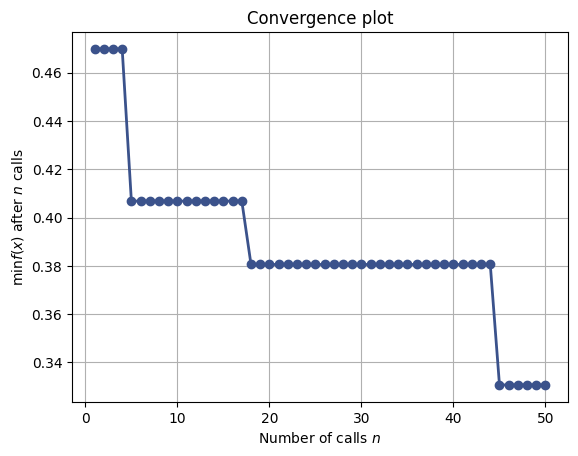

In [47]:
plot_convergence(res)

<Axes: >

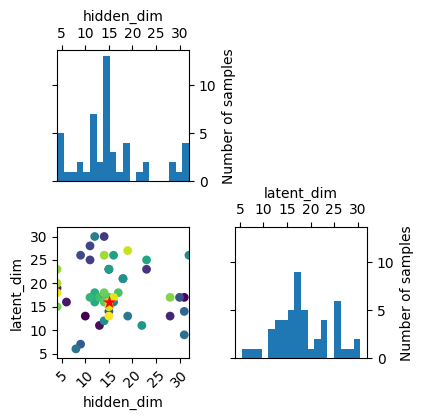

In [48]:
plot_evaluations(res)

<Axes: >

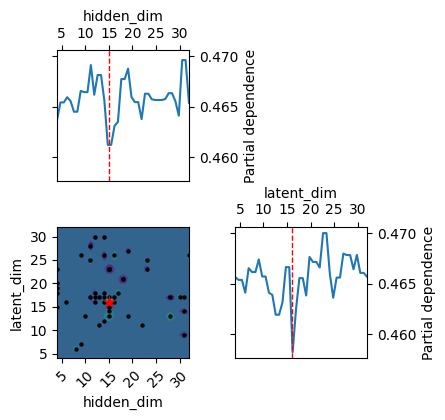

In [23]:
plot_objective(res)

<Axes: xlabel='hidden_dim', ylabel='latent_dim'>

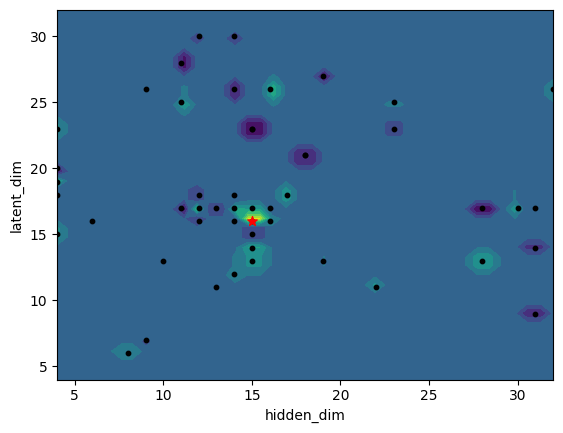

In [24]:
plot_objective_2D(res, dimension_identifier1='hidden_dim', dimension_identifier2='latent_dim')

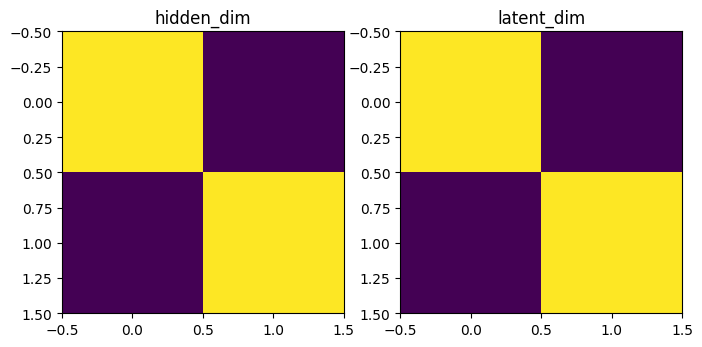

In [25]:
dim_names = [s.name for s in res.space]
x = np.array(res.x_iters)
y = np.array(res.func_vals)
df = pd.DataFrame({n:x[:, i] for i, n in enumerate(dim_names)})
df['func_vals'] = y
fig, axes = plt.subplots(nrows=1, ncols=len(dim_names), figsize=(8, 6))
for i in range(len(dim_names)):
    axes[i].imshow(df[[dim_names[i], 'func_vals']].corr(), cmap='viridis')
    axes[i].set_title(f'{dim_names[i]}')

#### Training Heuristics

In [50]:
best_model_name = "conv_classifier_ldim11_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch"
best_model_loss = pd.read_csv(save_filepath+best_model_name+'.csv')

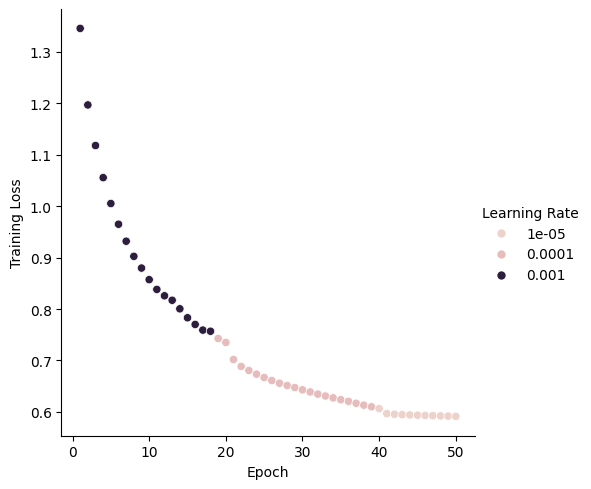

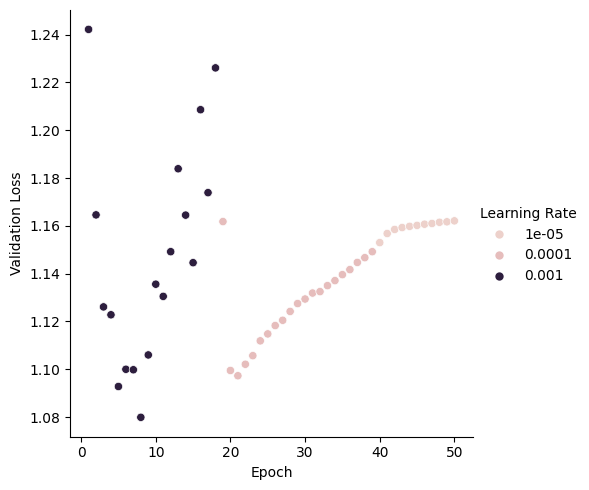

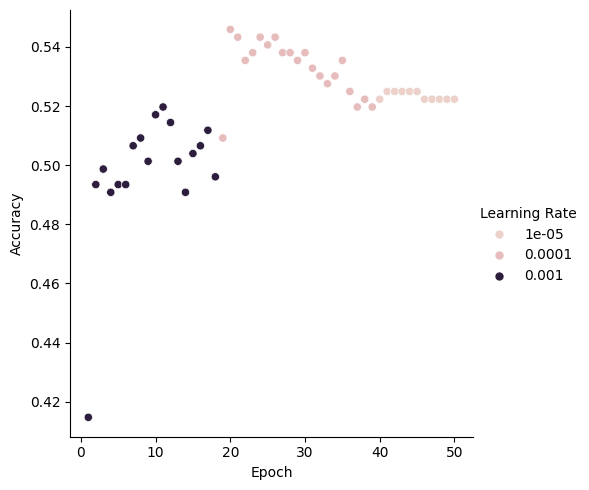

In [43]:
sns.relplot(data=best_model_loss, x='Epoch', y='Training Loss', hue='Learning Rate')
sns.relplot(data=best_model_loss, x='Epoch', y='Validation Loss', hue='Learning Rate')
sns.relplot(data=best_model_loss, x='Epoch', y='Accuracy', hue='Learning Rate')

In [44]:
def stopping_criterion(df, window_size):
    window_size = window_size
    sum_grad_ratios, mean_grad_ratios, var_grad_ratios = np.array([]), np.array([]), np.array([])
    for i in range(window_size, len(df)):
        loss_data = df.loc[i-window_size:i]
        past_train_loss = loss_data['Training Loss'].values
        past_val_loss = loss_data['Validation Loss'].values

        local_x = np.arange(len(past_train_loss))

        train_grad = np.gradient(past_train_loss, local_x)
        val_grad = np.gradient(past_val_loss, local_x)

        grad_ratio = -(train_grad / (val_grad + 1e-6))

        sum_grad_ratios=np.append(sum_grad_ratios, np.sum(grad_ratio))
        mean_grad_ratios=np.append(mean_grad_ratios, np.mean(grad_ratio))
        var_grad_ratios=np.append(var_grad_ratios, np.var(grad_ratio))
    return sum_grad_ratios, mean_grad_ratios, var_grad_ratios

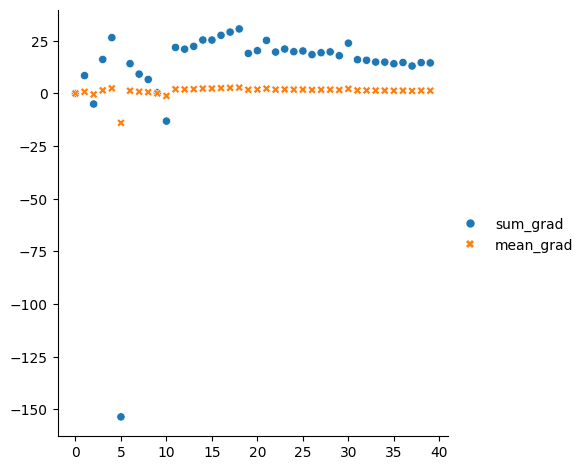

In [45]:
sum_grad_ratios, mean_grad_ratios, var_grad_ratios = stopping_criterion(df=best_model_loss, window_size=10)

sns.relplot(data={'sum_grad':sum_grad_ratios, 'mean_grad':mean_grad_ratios})#, 'var_grad':var_grad_ratios})

#### Training Statistics


In [31]:
temp_dfs = []
for f in os.listdir(save_filepath):
    if f.endswith('.csv'):
        filepath = os.path.join(save_filepath, f)

        temp_df = pd.read_csv(filepath)
        temp_df['Model Name'] = f

        temp_dfs.append(temp_df)
training_data = pd.concat(temp_dfs, ignore_index=True)

agg_training_data = training_data.groupby("Model Name").agg({
    "Epoch": ["max"],
    "Training Loss": ["last", "min"],
    "Validation Loss": ["last", "min"],
    "Accuracy": ["last", "max"],
    "Learning Rate": ["min"],
});

In [39]:
# approaching 1 is better
loss_overfit_scores = (agg_training_data['Validation Loss']['last']) / agg_training_data['Validation Loss']['min']
loss_overfit_scores = loss_overfit_scores.sort_values(ascending=True)
loss_overfit_scores

Model Name
conv_classifier_ldim7_convblocks3_hdim5_kernel(10, 2)_idBayesOpt4CustomArch.csv      1.018699
conv_classifier_ldim17_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.059110
conv_classifier_ldim13_convblocks3_hdim19_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.068075
conv_classifier_ldim11_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.076118
conv_classifier_ldim15_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch.csv     1.087086
conv_classifier_ldim16_convblocks3_hdim6_kernel(10, 2)_idBayesOpt4CustomArch.csv     1.087752
conv_classifier_ldim7_convblocks3_hdim9_kernel(10, 2)_idBayesOpt4CustomArch.csv      1.089625
conv_classifier_ldim12_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.101088
conv_classifier_ldim20_convblocks3_hdim4_kernel(10, 2)_idBayesOpt4CustomArch.csv     1.106134
conv_classifier_ldim17_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.107333
conv_classifier_ldim6_convblocks3_hdim8_kernel(10

In [40]:
# approaching 1 is better
acc_overfit_scores = agg_training_data['Accuracy']['max'] / ((agg_training_data['Accuracy']['last']) + 1e-12)
acc_overfit_scores = acc_overfit_scores.sort_values(ascending=True)
acc_overfit_scores

Model Name
conv_classifier_ldim26_convblocks3_hdim9_kernel(10, 2)_idBayesOpt4CustomArch.csv     1.000000
conv_classifier_ldim16_convblocks3_hdim6_kernel(10, 2)_idBayesOpt4CustomArch.csv     1.000000
conv_classifier_ldim16_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.003922
conv_classifier_ldim17_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.004504
conv_classifier_ldim11_convblocks3_hdim22_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.009217
conv_classifier_ldim12_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.009302
conv_classifier_ldim7_convblocks3_hdim5_kernel(10, 2)_idBayesOpt4CustomArch.csv      1.013825
conv_classifier_ldim17_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.015544
conv_classifier_ldim17_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.017544
conv_classifier_ldim14_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.018018
conv_classifier_ldim26_convblocks3_hdim32_kernel(

In [41]:
# approaching 1 is better
agg_overfit_score = acc_overfit_scores * loss_overfit_scores
agg_overfit_score

Model Name
conv_classifier_ldim11_convblocks3_hdim13_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.124787
conv_classifier_ldim11_convblocks3_hdim22_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.121849
conv_classifier_ldim12_convblocks3_hdim14_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.111331
conv_classifier_ldim13_convblocks3_hdim10_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.231997
conv_classifier_ldim13_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.221640
conv_classifier_ldim13_convblocks3_hdim19_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.088814
conv_classifier_ldim13_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.501732
conv_classifier_ldim14_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.156187
conv_classifier_ldim14_convblocks3_hdim31_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.333715
conv_classifier_ldim15_convblocks3_hdim15_kernel(10, 2)_idBayesOpt4CustomArch.csv    1.511716
conv_classifier_ldim15_convblocks3_hdim4_kernel(1

#### Animation creation

In [217]:
t0 = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00000/Embeddings_epoch_0/tensors.tsv"), sep='\t').values
t1 = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00050/Embeddings_epoch_50/tensors.tsv"), sep='\t').values
labels = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00050/Embeddings_epoch_50/metadata.tsv"), sep='\t').values
labels = np.array([int(s[7]) for s in labels[:, 0]])
t0.shape, t1.shape, labels

((3046, 96), (3046, 96), array([2, 0, 3, ..., 1, 3, 1]))

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

In [ ]:
tsne0 = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
t0_tsne = tsne0.fit_transform(t0)

tsne1 = TSNE(n_components=2, perplexity=30, n_iter=1200, random_state=42)
t1_tsne = tsne1.fit_transform(t1)

c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


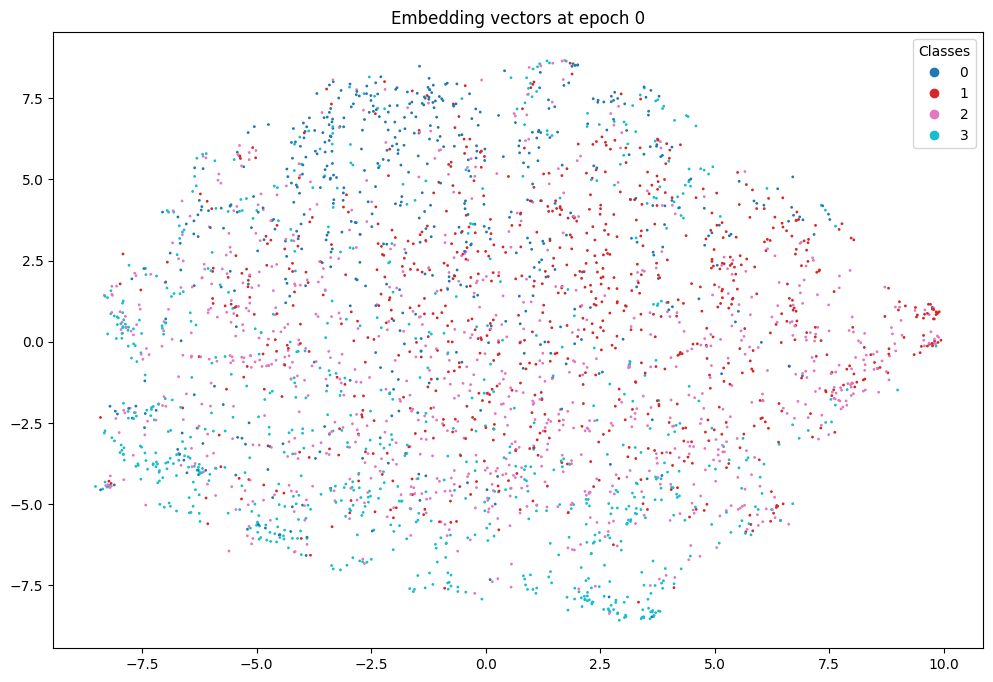

In [141]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(t0_tsne[:, 0], t0_tsne[:, 1], c=labels, cmap='tab10', s=1)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Embedding vectors at epoch 0')
plt.show()

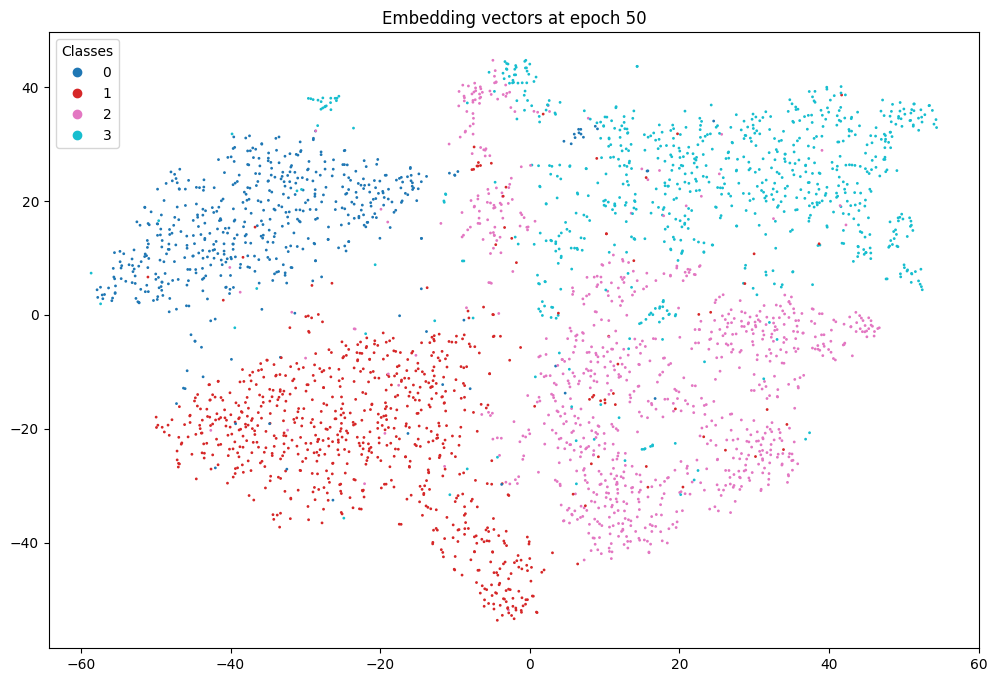

In [142]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(t1_tsne[:, 0], t1_tsne[:, 1], c=labels, cmap='tab10', s=1)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Embedding vectors at epoch 50')
plt.show()

#### Classification head

Train classification head on encoded feature representations, backpropagate through encoder aswell

In [ ]:
# load pretrained conv_ae

conv_ae_2 = ConvAE2d()
conv_ae_2.load_state_dict(torch.load('path_to_model/conv_ae.pth'))
conv_ae_2.eval()

# freeze all layers
for param in conv_ae.parameters():
    param.requires_grad = False  

# change last fc layers
num_features = conv_ae_2.fc.in_features
conv_ae_2.fc = nn.Linear(num_features, new_num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_ae_2.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(conv_ae_2.fc.parameters(), lr=1e-3)  # only train last layer
criterion = nn.CrossEntropyLoss()
